# In this Module
- Why Autograd?
- A Basic Example
- Autograd in Model Training
- Turning Autograd Off & On
- Autograd Profiler
- High-Level API

# Autograd
Autograd allows rapid and easy computation of multiple partial derivatives(gradients) over a complex computation.

In [3]:
# importing basic dependencies to visualize the plots
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

creating a sine function on interval ```[0,2pi]```

In [95]:
a = torch.linspace(0., 2.*math.pi, steps = 25, requires_grad = True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


In [96]:
# plotting the sine function using a as input.
b = torch.sin(a)
# plt.plot(a.detach(),b.detach())

In [97]:
# now performing some computation and then performing its derivative
c = 3*b
d = c+ 4


In [98]:
out = d.sum() # add all the elements of d.
print(out) 

tensor(100., grad_fn=<SumBackward0>)


tensor([ 3.0000e+00,  2.8978e+00,  2.5981e+00,  2.1213e+00,  1.5000e+00,
         7.7646e-01, -1.3113e-07, -7.7646e-01, -1.5000e+00, -2.1213e+00,
        -2.5981e+00, -2.8978e+00, -3.0000e+00, -2.8978e+00, -2.5981e+00,
        -2.1213e+00, -1.5000e+00, -7.7646e-01,  3.5775e-08,  7.7646e-01,
         1.5000e+00,  2.1213e+00,  2.5981e+00,  2.8978e+00,  3.0000e+00])


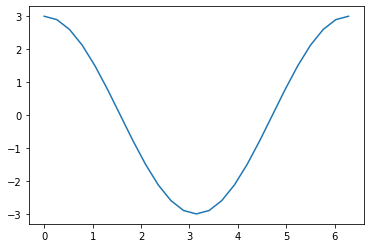

In [99]:
# using backpropagation
out.backward()
print(a.grad)
plt.plot(a.detach(),a.grad.detach())

# Autograd in Training
Using for actual Purpose

In [102]:
# simply definining the model architecture and creating sample input and output tensors.

In [173]:
BATCH_SIZE=16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):
    
    def __init__(self):
        # super ensures that the TinyModel inherits all the functionality of torch.nn.Module
        super(TinyModel,self).__init__()  
        
        self.layer1 = torch.nn.Linear(1000,100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100,10)
    # forward defines the forward pass of the neural network
    # it specify how the input is processed through layers of network.
    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

some_input = torch.randn(BATCH_SIZE,DIM_IN,requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE,DIM_OUT,requires_grad=False)

model = TinyModel()

1. in the forward pass
- the model is first passed through linear layer1.
- in the second layer, relu activation function max(0,z) is applied
- in 3rd layer it is again passed through a linear layer
- output of all the 3rd layer is returned from the forward pass.

 

In [174]:
# IF we look at the layers of the model, we examine that the values of the weights, and verify that they never changed
# since we didn't apply the gradient = true (or did back-propagation)

In [175]:
print(model.layer2.weight[0][0:10]) 
print(model.layer2.weight.grad) # grad = None

tensor([-0.0672,  0.0638,  0.0588, -0.0136,  0.0306,  0.0570, -0.0698, -0.0146,
        -0.0232,  0.0031], grad_fn=<SliceBackward0>)
None


# Now lets use the gradient 

In [176]:
# Stochastic Gradient Descent, learning rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
#prediction using input data
prediction = model(some_input)
# loss = sigma [(y-pred - y)^2]
loss = (ideal_output-prediction).pow(2).sum()
print(loss)

tensor(161.4231, grad_fn=<SumBackward0>)


Now, let's call ```loss.backward()``` and see what happens

In [177]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0672,  0.0638,  0.0588, -0.0136,  0.0306,  0.0570, -0.0698, -0.0146,
        -0.0232,  0.0031], grad_fn=<SliceBackward0>)
tensor([ 1.1771, -0.6772, -2.1421, -0.9297,  2.6605, -8.4190,  0.8321, -2.1545,
        -1.5586, -4.5715])


## Gradients have been computed 
## But the Weights didn't change

Weights didn't change since we didn't apply the optimizers


In [178]:
# The optimizer(SGD) is responsible for weight updatation.

In [179]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0684,  0.0645,  0.0609, -0.0126,  0.0279,  0.0655, -0.0706, -0.0125,
        -0.0216,  0.0077], grad_fn=<SliceBackward0>)
tensor([ 1.1771, -0.6772, -2.1421, -0.9297,  2.6605, -8.4190,  0.8321, -2.1545,
        -1.5586, -4.5715])


we see that the gradient remains the same-
and the weight for the layer2 is unpdated.

After calling ```optimizer.step()```, we need to call ```optimizer.zero_grad()```,or
else every time ```loss.backward()```, the gradient of the ```lr``` will accumulate

In [180]:
print(model.layer2.weight.grad[0][0:10])


tensor([ 1.1771, -0.6772, -2.1421, -0.9297,  2.6605, -8.4190,  0.8321, -2.1545,
        -1.5586, -4.5715])


In [181]:
# print(model.layer2.weight.grad[0][0:10])
for i in range(0,5):
    prediction = model(some_input)
    loss = (ideal_output-prediction).pow(2).sum()
    loss.backward()
    


after running the ```loss.backward()``` multiple times, the magnitude of most of the gradient becomes larger

i.e., it fails to make the gradient 0 or reach the global minima

In [182]:
print(model.layer2.weight.grad[0][0:10])

tensor([  9.9145,  -4.7582, -19.9170,  -2.2067,  13.7452, -49.9962,   8.7525,
         -4.1624,   3.1292, -20.4677])


In [184]:
optimizer.zero_grad()
print(model.layer2.weight.grad[0][0:10])

TypeError: 'NoneType' object is not subscriptable

# Turning the Autograd OFF and ON

```requires_grad = True```

In [185]:
a = torch.ones(2,3, requires_grad = True)
print(a)
b = 2*a
print(b)
a.requires_grad = False
b2 = 2*a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


 we see that ```b1``` has grad function but ```b2``` not, we turned grad for b2

## Temporary Off of autograd

In [187]:
a = torch.ones(2,3,requires_grad = True)*4
b = torch.ones(2,3,requires_grad = True)*3
c1 = a + b
print(c1)

# temporarily stopping autograd function
with torch.no_grad():
    c2 = a + b
print(c2)

c3  = a*b
print(c3)

tensor([[7., 7., 7.],
        [7., 7., 7.]], grad_fn=<AddBackward0>)
tensor([[7., 7., 7.],
        [7., 7., 7.]])
tensor([[12., 12., 12.],
        [12., 12., 12.]], grad_fn=<MulBackward0>)


 we see that for ```c2``` it is OFF but for ```c3``` its again ON

```torch.no_grad()``` can also be used as a function or method decorator:

In [188]:
def add_tensors(x,y):
    return x+y
@torch.no_grad()
def add_tensors_2(x,y):
    return x+y

a = torch.ones(2,4,requires_grad=True)*2
b = torch.ones(2,4,requires_grad=True)*3

c1 = add_tensors(a,b)
print(c1)
c2 = add_tensors_2(a,b)
print(c2)

tensor([[5., 5., 5., 5.],
        [5., 5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5., 5.],
        [5., 5., 5., 5.]])


In [189]:
# we see that the grad is OFF for second add_tensor function

```detach()``` to detach from the current graph

In [190]:
x = torch.rand(5,requires_grad=True)
y = x.detach()
print(x)
print(y)

tensor([0.1369, 0.8898, 0.8635, 0.0440, 0.6640], requires_grad=True)
tensor([0.1369, 0.8898, 0.8635, 0.0440, 0.6640])


In [191]:
# Y- is detached from the x. now wont be able to use gradient for y.

# Autograd and In-Place Operation

In most cases we used another variable find and print the computations,
using _ inplace operation destroy our result and may throw error.
so be carefull while using _inplace operations

In [192]:
a = torch.linspace(0., 2.*math.pi, steps = 10, requires_grad = True)
torch.sin(a)

tensor([ 0.0000e+00,  6.4279e-01,  9.8481e-01,  8.6603e-01,  3.4202e-01,
        -3.4202e-01, -8.6603e-01, -9.8481e-01, -6.4279e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)

In [193]:
torch.sin_(a)

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [194]:
# it throws an error.

# Autograd Profiler

Autograd tracks every step of your computation in details.

In [196]:
device = torch.device('cpu')
run_on_gpu = False

if torch.cuda.is_available():
    print('available')
    device = torch.device('cuda')
    run_on_gpu = True

x = torch.randn(2,3, requires_grad=True)
y = torch.randn(2,3, requires_grad = True)
z = torch.randn(2,3, requires_grad = True)

with torch.autograd.profiler.profile(use_cuda = run_on_gpu) as prf:
    for _ in range(1000):
        z = (z/x)*y
print(prf.key_averages().table(sort_by='self_cpu_time_total'))

-------------  ------------  ------------  ------------  ------------  ------------  ------------  
         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::div        52.59%       4.481ms        52.59%       4.481ms       4.481us          1000  
    aten::mul        47.41%       4.039ms        47.41%       4.039ms       4.039us          1000  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 8.520ms



# High-level API

# Back Propagation

In [1]:
import torch

# derivative

## x^n --> n*x^(n-1)

In [7]:
x = torch.tensor(4.4,requires_grad=True)
# requires_grad=True --> will allow back-propagation and hence value change
# during it.

In [8]:
x

tensor(4.4000, requires_grad=True)

In [9]:
y= x**2  # y= x^2

In [69]:
y

tensor([[ 36.0000,  50.8640,  12.0000],
        [ 12.0000, 150.0000, 150.0000],
        [  2.0000, 252.0000, 252.0000]], grad_fn=<AddBackward0>)

#### performing backpropagation: y = 2x

In [13]:
y.backward() # compute the gradient
# backpropagation initialized

In [16]:
x.grad

tensor(8.8000)

In [17]:
# these functions and methods will be widely used while creating ANN, CNN


In [49]:
# multi-nested list
lst = [[3.,3.4,2.],[2.,5.,5.],[1.,6.,6]]
torch_input=torch.tensor(lst,requires_grad=True)

In [50]:
torch_input

tensor([[3.0000, 3.4000, 2.0000],
        [2.0000, 5.0000, 5.0000],
        [1.0000, 6.0000, 6.0000]], requires_grad=True)

In [51]:
# initilizing a polynomial function in torch_input: y= x**3 + x**2
y = torch_input**3+torch_input**2

In [52]:
y

tensor([[ 36.0000,  50.8640,  12.0000],
        [ 12.0000, 150.0000, 150.0000],
        [  2.0000, 252.0000, 252.0000]], grad_fn=<AddBackward0>)

In [53]:
# since pytorch autograd only supports the gradient of scaler data
# and y is not a scaler, so we converted it to z = y.sum() to take the sum of all values.
# now we can apply the derivative function.
z=y.sum()

In [54]:
z

tensor(916.8640, grad_fn=<SumBackward0>)

In [55]:
# derivative of y wrt x(torch_input)
z.backward()
# -->y= 3x**2 + 2x

In [44]:
print(torch_input.grad)

tensor([[ 33.0000,  41.4800,  16.0000],
        [ 16.0000,  85.0000,  85.0000],
        [  5.0000, 120.0000, 120.0000]])


# From  Final VDO

In [1]:
# if we don't declare a sum, then we must pass a vector to find the gradient.
# and it will be infact a Jacobian-matrix of gradients.

In [4]:
x = torch.randn(3,requires_grad = True)
print(x)
y = x+2
z = y*y*2
v = torch.tensor([0.1,1.0,0.001],dtype = torch.float32)
z.backward(v) # dz/dv
print(x.grad)

tensor([-1.6189,  0.0196,  0.7256], requires_grad=True)
tensor([0.1525, 8.0783, 0.0109])


# how we can stop gradient function call.

1. ```x.requires_grad_(False)1``` In place change
2. ```x.detach()```
3. ```with torch.no_grad():```

In [6]:
print(x)
y =  x.detach()
print(y)
with torch.no_grad():
    z = x*2
    print(z)

tensor([-1.6189,  0.0196,  0.7256], requires_grad=True)
tensor([-1.6189,  0.0196,  0.7256])
tensor([-3.2377,  0.0392,  1.4512])


In [7]:
# we see that only x has grad-true marked other are free of gradients.

Some times if we don't turn off the gradient it get accumulated in the next iterations

In [11]:
# let's see the same for more than one iterations.
weights = torch.ones(4, requires_grad = True)
for epoch in range(5):
    model_output = (weights*3).sum()
    model_output.backward()
    print(weights.grad)

tensor([3., 3., 3., 3.])
tensor([6., 6., 6., 6.])
tensor([9., 9., 9., 9.])
tensor([12., 12., 12., 12.])
tensor([15., 15., 15., 15.])


In [12]:
# we see that the gradients got summed every iterations.
# so we must turn off after each iteration.

In [14]:
# let's see the same for more than one iterations.
weights = torch.ones(4, requires_grad = True)
for epoch in range(5):
    model_output = (weights*3).sum()
    model_output.backward()
    print(weights.grad)
    weights.grad.zero_()

tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])


In [15]:
# when we are working with optimizers we'll do the same in following ways.

In [ ]:
optimizer = torch.optim.SGD(weigths, lr = 0.01)
optimizer.step()
optimizer.zero_grad()

 # Backpropagation

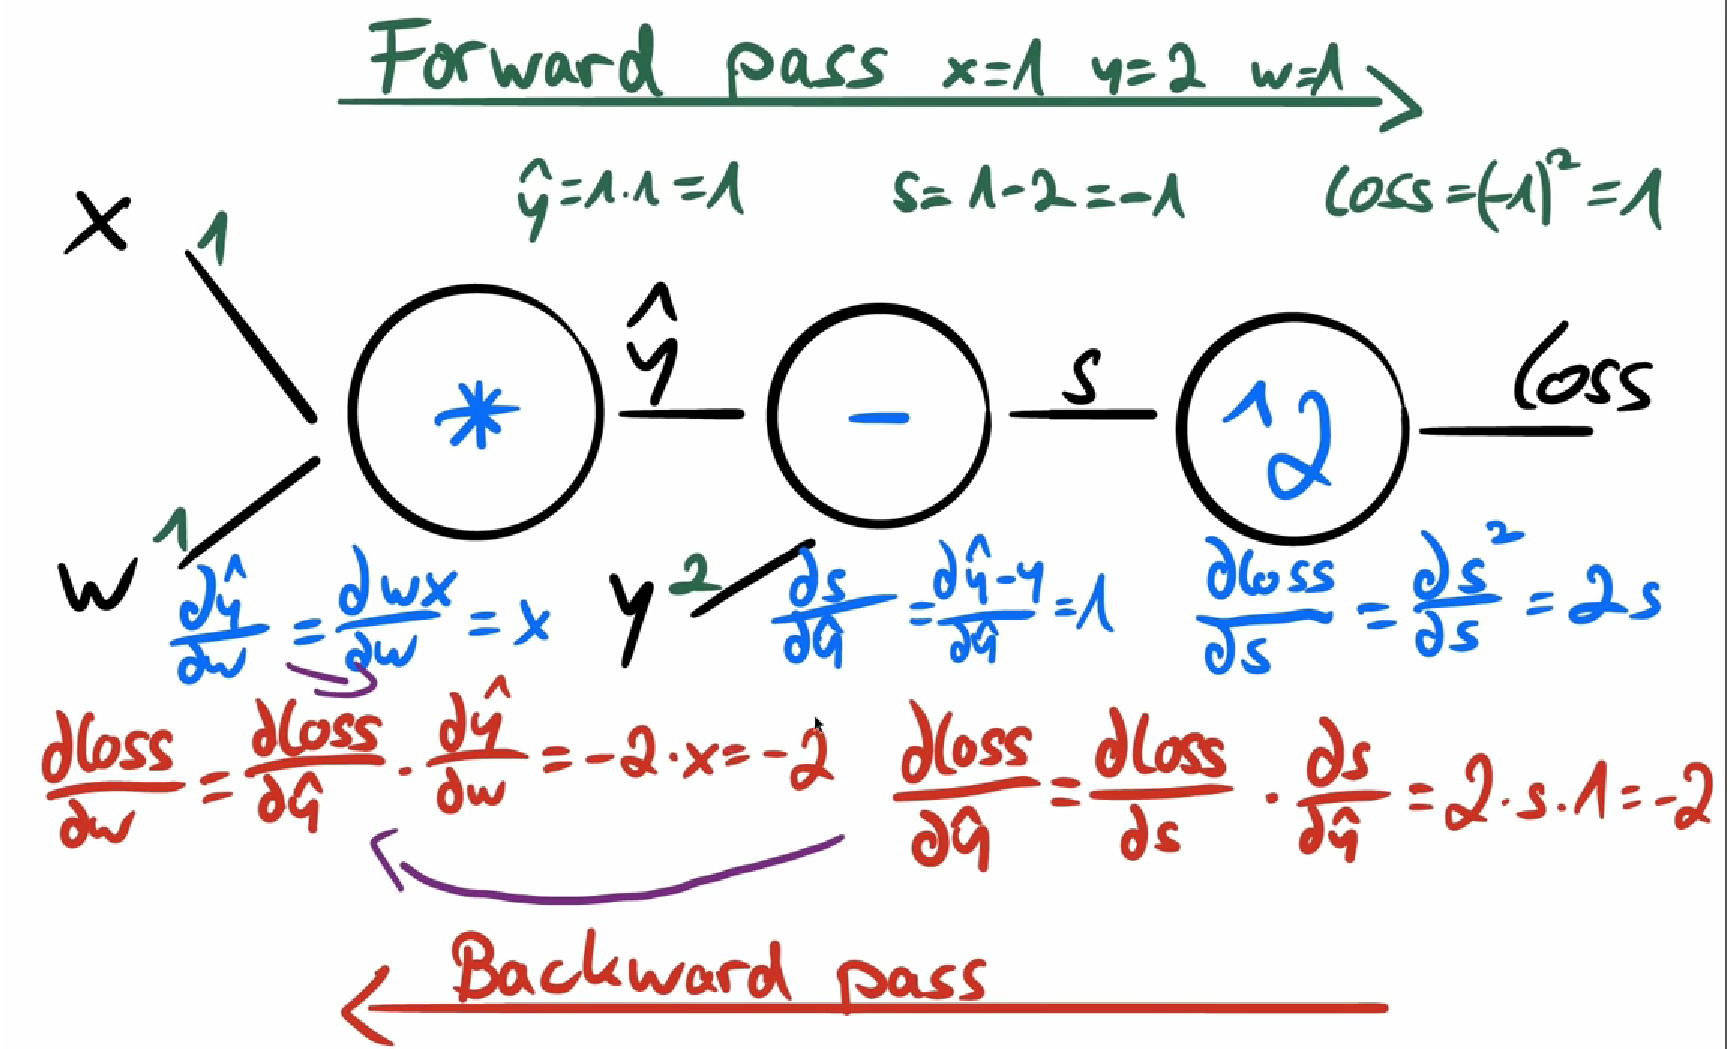

In [16]:
# let's code the same.
# x = 1, y = 2, w = 1
# loss = -2
# gradient = -2

In [18]:
# Initialization
x = torch.tensor(1.0)
y = torch.tensor(2.0)
w = torch.tensor(1.0,requires_grad =True)

# Forward Pass
y_hat = w*x
loss =( y_hat - y)**2
print(loss)

# Backward pass
loss.backward()
print(w.grad)

# Update the weights
# Next Forward Pass and backward Pass ............. do more iterations.

tensor(1., grad_fn=<PowBackward0>)
tensor(-2.)
